In [1]:
import pandas as pd

In [37]:
dataset = pd.read_csv('news.csv')

In [40]:
print(dataset.columns)

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


In [41]:
dataset = dataset.dropna()

In [42]:
dataset_d= dataset.drop('Unnamed: 0', axis=1)

In [43]:
dataset_d.head

<bound method NDFrame.head of                                                   title  \
0                          You Can Smell Hillary’s Fear   
1     Watch The Exact Moment Paul Ryan Committed Pol...   
2           Kerry to go to Paris in gesture of sympathy   
3     Bernie supporters on Twitter erupt in anger ag...   
4      The Battle of New York: Why This Primary Matters   
...                                                 ...   
6330  State Department says it can't find emails fro...   
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332  Anti-Trump Protesters Are Tools of the Oligarc...   
6333  In Ethiopia, Obama seeks progress on peace, se...   
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
0     Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1     Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2     U.S. Secretary of State John F. Kerry said Mon...  REAL  
3    

In [44]:
real_news = dataset_d.query("label == 'REAL'")
fake_news = dataset_d.query("label == 'FAKE'")

**Data Preprocessing**

In [45]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [47]:
import re
import nltk
nltk.download('stopwords')

corpus = []
for i in range(0, len(dataset_d)):
    review = re.sub('[^a-zA-Z]', ' ', dataset_d['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to C:\Users\TOM
[nltk_data]     ARNOLD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

In [49]:
X = tfidf_v.fit_transform(corpus).toarray()
y = dataset_d['label']

In [50]:
# Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Model building - Passive Aggresive Classifier**

In [51]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifier = PassiveAggressiveClassifier(max_iter=1000)

In [52]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.918


In [53]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


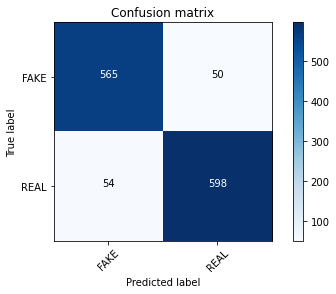

In [54]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

**Validate on an unseen datapoint**

In [60]:
review = re.sub('[^a-zA-Z]', ' ', fake_news['text'][4783])
review = review.lower()
review = review.split()
    
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
review

'octob least arrest peac protest stand rock reserv attempt stop dakota access pipelin dapl pose major threat drink water peopl stand rock paid energi transfer partner parent compani dakota access llc dapl set embed sacr burial ground stand rock area dapl secur use attack dog peac peopl intimid protest polic sniper seen peak armor vehicl aim directli unarm protest water protector brutal offic use color law help dakota access llc trampl treati us cheyenn sioux arapaho crow assiniboin mandan hidatsa arikara nation protest arrest handcuff zipti place fix wrist stuf cage made dog crowd cell number written arm mani brutal assault taze even mace women strip search front male offic accord protest elderli woman diabet blood sugar level danger high given medic attent mere releas deal whatev health complic complet zip tie use bind peopl hand number protest report zip tie tie tightli around protest wrist hand turn purpl result reduc blood circul car area impound offic access vehicl allegedli searc

In [59]:
val = tfidf_v.transform([review]).toarray()

In [61]:
classifier.predict(val)


array(['FAKE'], dtype='<U4')

**Save model and vectorizer**

In [62]:
import pickle


In [63]:
pickle.dump(classifier, open('model2.pkl', 'wb'))

In [64]:
pickle.dump(tfidf_v, open('tfidfvect2.pkl', 'wb'))

**Load model and vectorizer to predict the previous datapoint**

In [65]:
joblib_model = pickle.load(open('model2.pkl', 'rb'))

In [66]:
joblib_vect = pickle.load(open('tfidfvect2.pkl', 'rb'))

In [67]:
val_pkl = joblib_vect.transform([review]).toarray()

In [68]:
joblib_model.predict(val_pkl)

array(['FAKE'], dtype='<U4')